Author: Pascal, pascal@bayesimpact.org

Date: 2019-06-25

# ROME update from v338 to v339

In June 2019 a new version of the ROME was released. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v339. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas as pd

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '338'
NEW_VERSION = '339'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
0 deleted files


So we have the same set of files in both versions: good start.

Now let's set up a dataset that, for each table, links both the old and the new file together.

In [3]:
# Load all ROME datasets for the two versions we compare.
VersionedDataset = collections.namedtuple('VersionedDataset', ['basename', 'old', 'new'])
rome_data = [VersionedDataset(
        basename=path.basename(f),
        old=pd.read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=pd.read_csv(f))
    for f in sorted(new_version_files)]

def find_rome_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_{}_v{}_utf8.csv'.format(partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [d.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in rome_data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

All files have the same columns as before: still good.

Now let's see for each file if there are more or less rows.

In [5]:
same_row_count_files = 0
for dataset in rome_data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d}/{:d} values added in {}'.format(
            diff, len(dataset.new.index), dataset.basename))
    elif diff < 0:
        print('{:d}/{:d} values removed in {}'.format(
            -diff, len(dataset.old.index), dataset.basename))
    else:
        same_row_count_files += 1
print('{:d}/{:d} files with the same number of rows'.format(
    same_row_count_files, len(rome_data)))

173/31293 values added in unix_coherence_item_v339_utf8.csv
4/11717 values added in unix_cr_gd_dp_appellations_v339_utf8.csv
51/2043 values added in unix_item_arborescence_v339_utf8.csv
11/13533 values added in unix_item_v339_utf8.csv
177/42886 values added in unix_liens_rome_referentiels_v339_utf8.csv
51/7462 values added in unix_referentiel_activite_riasec_v339_utf8.csv
2/8971 values added in unix_referentiel_activite_v339_utf8.csv
4/11061 values added in unix_referentiel_appellation_v339_utf8.csv
1/4880 values added in unix_referentiel_competence_v339_utf8.csv
1/764 values added in unix_referentiel_env_travail_v339_utf8.csv
4/4223 values added in unix_rubrique_mobilite_v339_utf8.csv
10/21 files with the same number of rows


There are some minor changes in many files, but based on my knowledge of ROME, none from the main files.

The most interesting ones are in referentiel_appellation, item, and liens_rome_referentiels, so let's see more precisely.

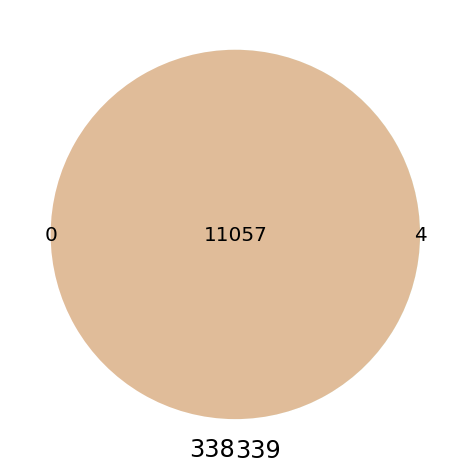

In [6]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')

new_jobs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
obsolete_jobs = set(jobs.old.code_ogr) - set(jobs.new.code_ogr)
stable_jobs = set(jobs.new.code_ogr) & set(jobs.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_jobs), len(new_jobs), len(stable_jobs)), (OLD_VERSION, NEW_VERSION));

Alright, so the only change seems to be 4 new jobs added. Let's take a look (only showing interesting fields):

In [7]:
pd.options.display.max_colwidth = 2000
jobs.new[jobs.new.code_ogr.isin(new_jobs)][['code_ogr', 'libelle_appellation_long', 'code_rome']]

,code_ogr,libelle_appellation_long,code_rome
3927,140971,Marchand / Marchande de bestiaux,D1107
3928,140972,Steward / Hôtesse de transport maritime,G1101
3929,140973,Conseiller médiateur / Conseillère médiatrice en numérique,G1202
3930,140974,Responsable d''espace de médiation numérique,G1202


These seems to be refinements of existing jobs, and two new ones are related to digital mediation.

OK, let's check at the changes in items:

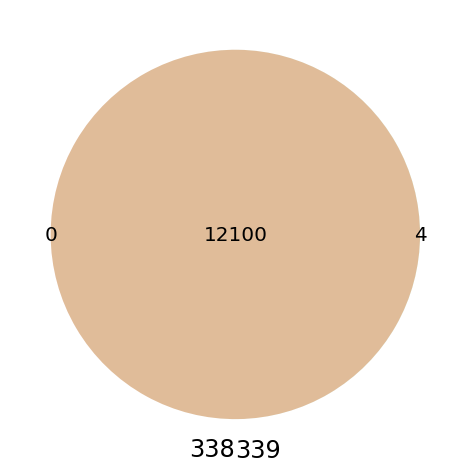

In [8]:
items = find_rome_dataset_by_name(rome_data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION));

As anticipated it is a very minor change (hard to see it visually): there are 4 new ones have been created. Let's have a look at them.

In [9]:
items.new[items.new.code_ogr.isin(new_items)].head()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
12765,140975,"Accompagner les publics vers l''autonomie dans les usages, les pratiques des outils et des services numériques",2,9,NaN,NaN,NaN
12766,140976,Lutter contre le gaspillage alimentaire,2,9,NaN,NaN,NaN
12767,140977,Principes de l''éco-conduite,1,10,NaN,NaN,NaN
12768,140977,Principes de l''éco-conduite,1,7,NaN,NaN,NaN
12769,140978,"Espace collaboratif (FabLab, Espace public numérique EPN, Espace de coworking, ...)",5,5,NaN,NaN,NaN


The new ones seem legit to me.

The changes in `liens_rome_referentiels` include changes for those items, so let's only check the changes not related to those.

In [10]:
links = find_rome_dataset_by_name(rome_data, 'liens_rome_referentiels')
old_links_on_stable_items = links.old[links.old.code_ogr.isin(stable_items)]
new_links_on_stable_items = links.new[links.new.code_ogr.isin(stable_items)]

old = old_links_on_stable_items[['code_rome', 'code_ogr']]
new = new_links_on_stable_items[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added    164
Name: _diff, dtype: int64

So in addition to the added items, there are few fixes. Let's have a look at them:

In [11]:
job_group_names = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome').new.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
display(links_merged[links_merged._diff == 'removed'].dropna().head(5))
links_merged[links_merged._diff == 'added'].dropna().head(5)


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
31120,E1101,119308,right_only,added,Animation de site multimédia,Réglement Général européen sur la Protection des Données (RGPD)
31121,E1101,125866,right_only,added,Animation de site multimédia,Maîtriser la e-reputation d''une entreprise
31122,E1106,115961,right_only,added,Journalisme et information média,Langue étrangère - Albanais
31123,E1106,115962,right_only,added,Journalisme et information média,Langue étrangère - Arabe
31124,E1106,115965,right_only,added,Journalisme et information média,Langue étrangère - Bulgare


Those fixes make sense (not sure why they were not done before, but let's not complain: it is fixed now).

That's all the changes we wanted to check (no change in `referentiel_code_rome`).

# Conclusion

The new version of ROME, v339, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/files/live/sites/peorg/files/documents/Statistiques-et-analyses/Open-data/ROME/ROME_AppropriationThematique.pdf). The transition should be transparent with a very small advantage over the old version.